In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

hist_path = "Coca-Cola_stock_history.csv"
info_path = "Coca-Cola_stock_info.csv"

hist = pd.read_csv(hist_path)
info = pd.read_csv(info_path)

date_clean = (
    hist['Date'].astype(str)
    .str.replace(r'(Z|[+-]\d{2}:\d{2})$', '', regex=True)
)
hist['Date'] = pd.to_datetime(date_clean, errors='coerce')
hist = hist.sort_values('Date').reset_index(drop=True)


In [14]:
# Cleaning
hist_clean = hist.copy()
for col in ['Open','High','Low','Close']:
    if col in hist_clean.columns:
        hist_clean[col] = hist_clean[col].ffill()
num_cols = hist_clean.select_dtypes(include=[np.number]).columns.tolist()
hist_clean[num_cols] = hist_clean[num_cols].fillna(0)
hist_clean = hist_clean.dropna(subset=['Date','Close']).reset_index(drop=True)


In [15]:
# Features
df = hist_clean.copy()
for w in [5, 20, 50, 200]:
    df[f"MA_{w}"] = df['Close'].rolling(window=w, min_periods=1).mean()
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20, min_periods=1).std()
df['HL_Spread'] = (df['High'] - df['Low']) / df['Close']
if 'Volume' in df.columns:
    df['Volume_Change'] = df['Volume'].pct_change().replace([np.inf,-np.inf], np.nan).fillna(0)
df = df.fillna(0)


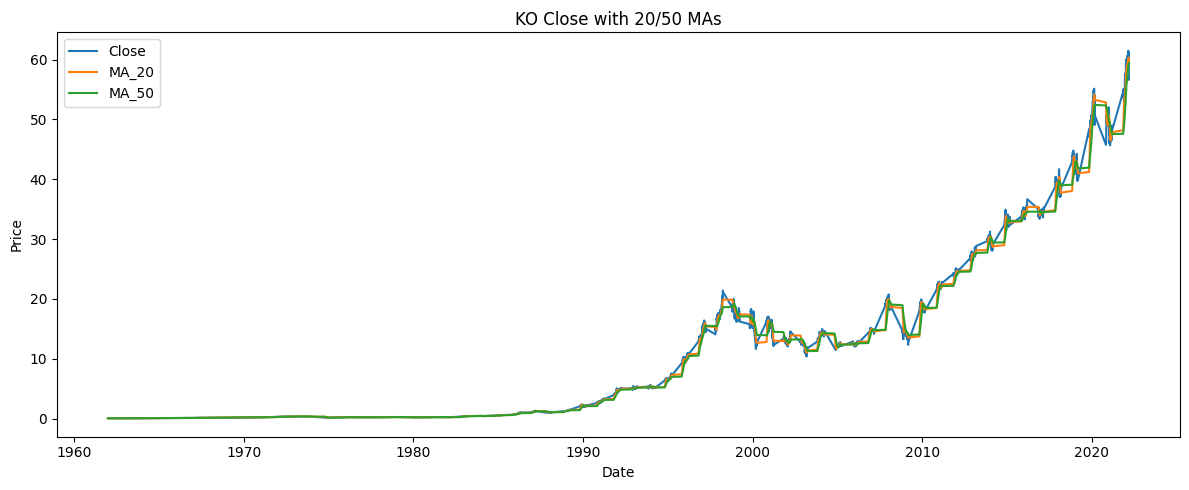

In [16]:
# Visuals
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_20'], label='MA_20')
plt.plot(df['Date'], df['MA_50'], label='MA_50')
plt.title("KO Close with 20/50 MAs"); plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()

/tmp/ipython-input-900436221.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vol_monthly = df.set_index('Date')['Volume'].resample('M').sum()


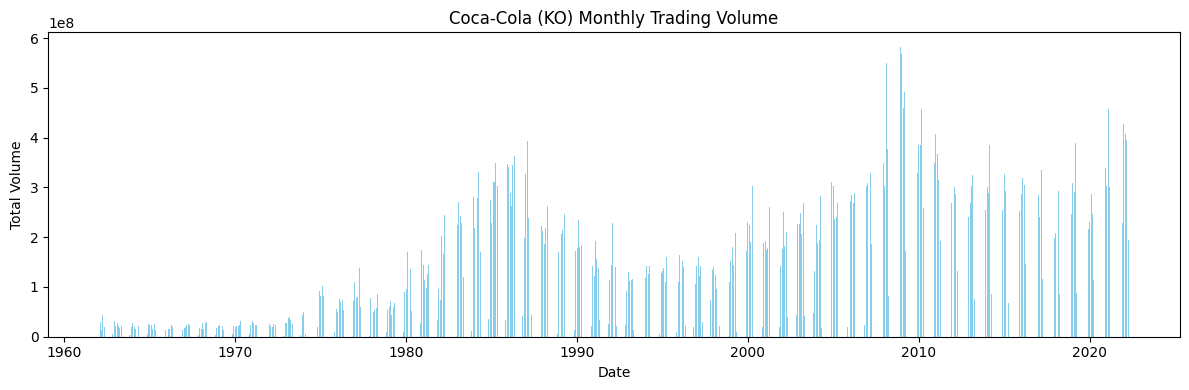

In [17]:
if 'Volume' in df.columns:
    # Monthly aggregated volume for readability
    vol_monthly = df.set_index('Date')['Volume'].resample('M').sum()
    plt.figure(figsize=(12,4))
    plt.bar(vol_monthly.index, vol_monthly.values, width=20, color='skyblue')
    plt.title("Coca-Cola (KO) Monthly Trading Volume")
    plt.xlabel("Date"); plt.ylabel("Total Volume")
    plt.tight_layout(); plt.show()

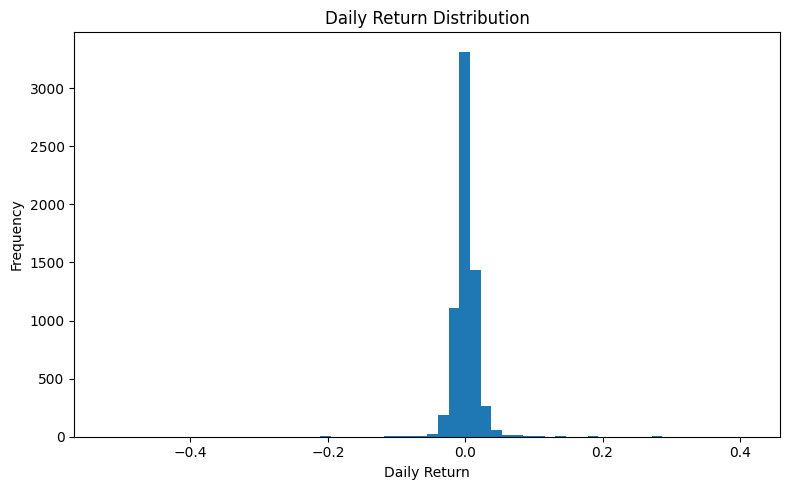

In [18]:
plt.figure(figsize=(8,5))
plt.hist(df['Daily_Return'].dropna().values, bins=60)
plt.title("Daily Return Distribution"); plt.xlabel("Daily Return"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()


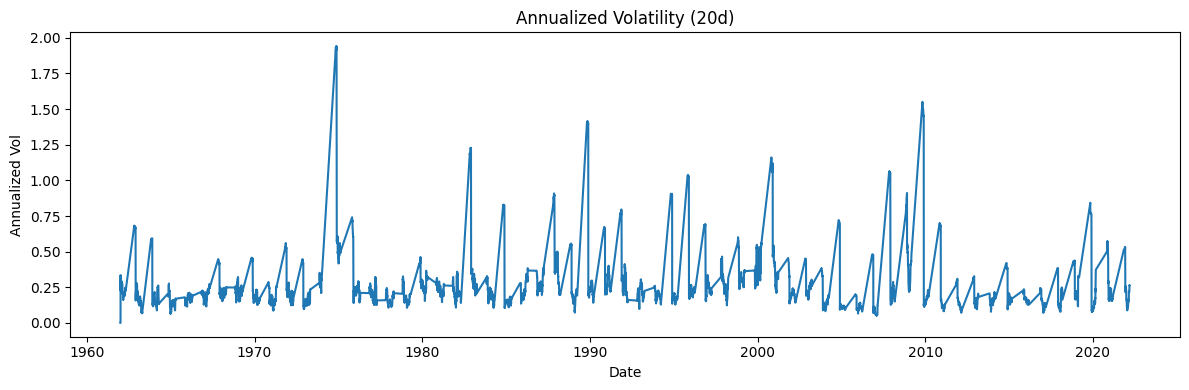

In [19]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], (df['Volatility_20']*np.sqrt(252)).values)
plt.title("Annualized Volatility (20d)"); plt.xlabel("Date"); plt.ylabel("Annualized Vol"); plt.tight_layout(); plt.show()

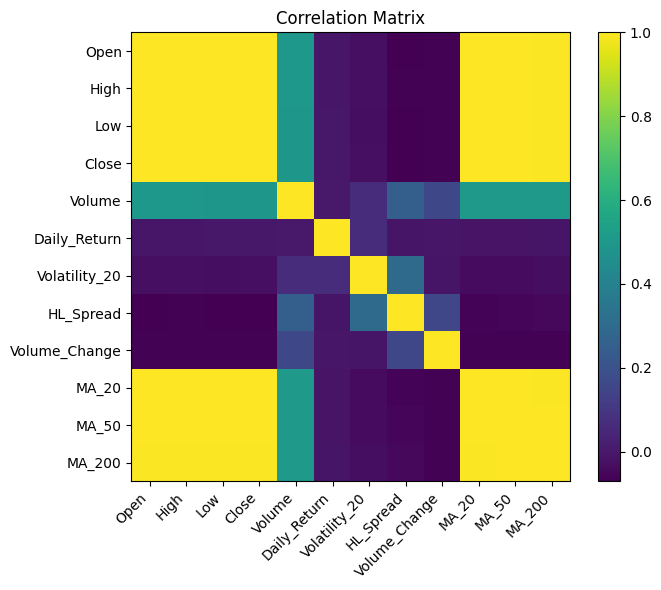

In [20]:
avail = [c for c in ['Open','High','Low','Close','Volume','Daily_Return','Volatility_20','HL_Spread','Volume_Change','MA_20','MA_50','MA_200'] if c in df.columns]
corr = df[avail].corr()
plt.figure(figsize=(7,6))
plt.imshow(corr, aspect='auto', interpolation='nearest')
plt.xticks(ticks=np.arange(len(avail)), labels=avail, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(avail)), labels=avail)
plt.title("Correlation Matrix"); plt.colorbar(); plt.tight_layout(); plt.show()


In [21]:
# Model
feature_cols = avail
X = df[feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0)
y = df['Close']

split_idx = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = df['Date'].iloc[split_idx:]

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

import numpy as np
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print({"MAE":mae, "RMSE":rmse, "R2":r2, "MAPE(%)":mape})

{'MAE': 12.68394619133524, 'RMSE': np.float64(17.079732623359604), 'R2': -0.8969011796701774, 'MAPE(%)': np.float64(30.412080449682694)}


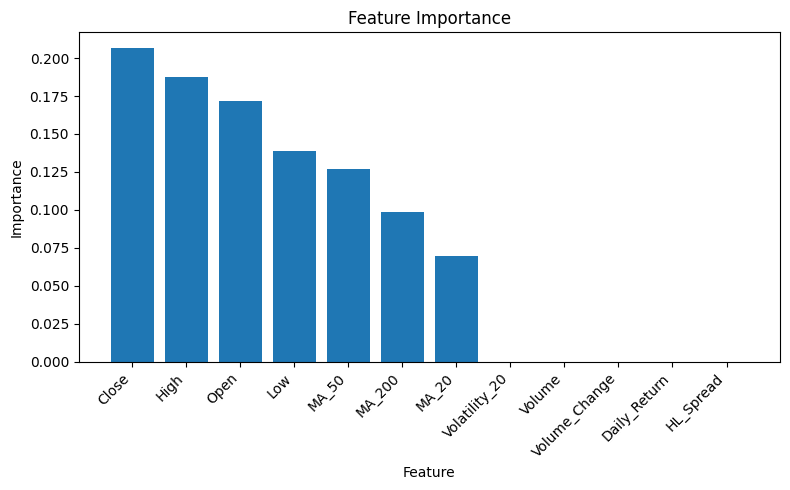

In [22]:
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.bar(importances.index, importances.values)
plt.title("Feature Importance"); plt.xlabel("Feature"); plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

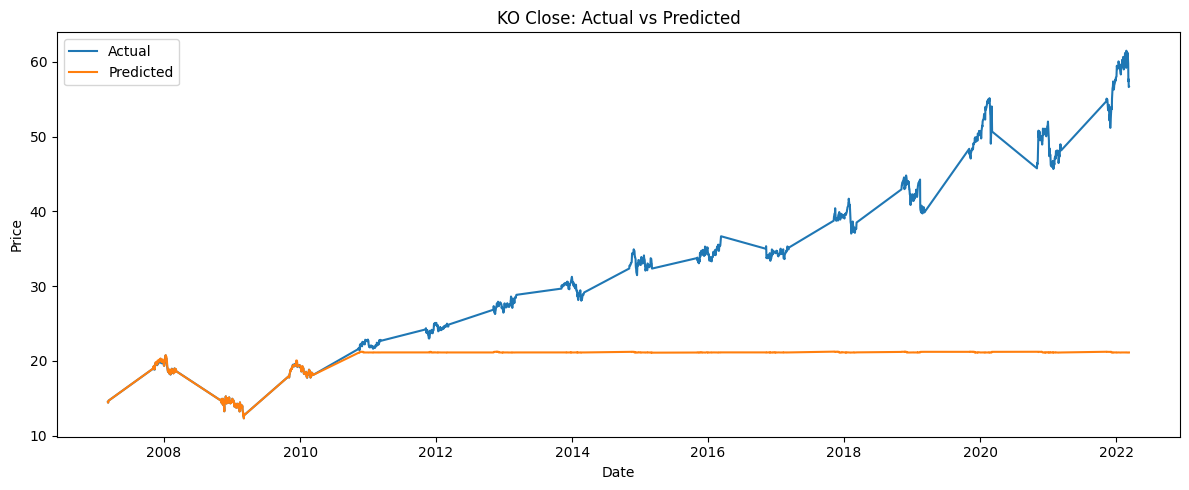

In [23]:

plt.figure(figsize=(12,5))
plt.plot(dates_test.values, y_test.values, label="Actual")
plt.plot(dates_test.values, y_pred, label="Predicted")
plt.title("KO Close: Actual vs Predicted"); plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(); plt.tight_layout(); plt.show()

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Features
feature_cols = [c for c in [
    'Open','High','Low','Volume','Daily_Return','Volatility_20',
    'HL_Spread','Volume_Change','MA_20','MA_50','MA_200'
] if c in df.columns]

X = df[feature_cols].replace([np.inf,-np.inf], np.nan).fillna(0)
y = df['Close']

split_idx = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = df['Date'].iloc[split_idx:]

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions
df["Predicted_Close"] = rf.predict(X)

# Metrics
mae  = mean_absolute_error(y, df["Predicted_Close"])
rmse = np.sqrt(mean_squared_error(y, df["Predicted_Close"]))
r2   = r2_score(y, df["Predicted_Close"])
mape = np.mean(np.abs((y - df["Predicted_Close"]) / y)) * 100

metrics = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R²", "MAPE (%)"],
    "Value": [mae, rmse, r2, mape]
})

# Feature importances
importances = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

with pd.ExcelWriter("KO_model_output.xlsx") as writer:
    df.to_excel(writer, sheet_name="Predictions", index=False)
    metrics.to_excel(writer, sheet_name="Metrics", index=False)
    importances.to_excel(writer, sheet_name="Feature_Importances", index=False)

print("✅ Excel file saved: KO_model_output.xlsx (with Predictions, Metrics, and Feature Importances)")


✅ Excel file saved: KO_model_output.xlsx (with Predictions, Metrics, and Feature Importances)
